<a href="https://colab.research.google.com/github/KeshriPooja/Modeling-Technique/blob/master/tensorflow_object_detection_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to train an object detection model easy for free](https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/) | DLology Blog

## Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [130]:
# If you forked the repository, you can replace the link.
repo_url = 'https://github.com/Tony607/object_detection_demo'

# Number of training steps.
num_steps = 2000 # 200000

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    },
    'faster_rcnn_resnet50': {
        'model_name': 'faster_rcnn_resnet50_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_resnet50_pets.config',
        'batch_size': 12
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'faster_rcnn_resnet50'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Clone the `object_detection_demo` repository or your fork.

In [2]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'object_detection_demo'...
remote: Enumerating objects: 124, done.
remote: Total 124 (delta 0), reused 0 (delta 0), pack-reused 124
Receiving objects: 100% (124/124), 11.16 MiB | 33.31 MiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/object_detection_demo
Already up to date.


In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
!pip install tf_slim

     |████████████████████████████████| 358kB 7.0MB/s 


In [5]:
!pip show tensorflow

Name: tensorflow
Version: 1.15.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /tensorflow-1.15.2/python3.7
Requires: gast, wrapt, keras-applications, tensorboard, keras-preprocessing, grpcio, termcolor, six, protobuf, google-pasta, numpy, absl-py, wheel, opt-einsum, astor, tensorflow-estimator
Required-by: stable-baselines, magenta, kapre


## Install required packages

In [6]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
Selecting previously unselected package python-bs4.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!rm -r /content/object_detection_demo/data/images/train  
!rm -r /content/object_detection_demo/data/images/test

In [10]:
%pwd

'/content/models/research'

In [13]:
!cp -r /content/drive/MyDrive/diagram_sample/train  /content/object_detection_demo/data/images/
!cp -r /content/drive/MyDrive/diagram_sample/test /content/object_detection_demo/data/images/

## Prepare `tfrecord` files

Use the following scripts to generate the `tfrecord` files.
```bash
# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
python xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations

# Convert test folder annotation xml files to a single csv.
python xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv

# Generate `train.record`
python generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt

# Generate `test.record`
python generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt
```

In [14]:
%cd {repo_dir_path}

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations

# Convert test folder annotation xml files to a single csv.
!python xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv

# Generate `train.record`
!python generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt

# Generate `test.record`
!python generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt

/content/object_detection_demo
Successfully converted xml to csv.
Generate `data/annotations/label_map.pbtxt`
Successfully converted xml to csv.


W0627 11:31:19.629259 140295537174400 module_wrapper.py:139] From generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0627 11:31:19.645926 140295537174400 module_wrapper.py:139] From generate_tfrecord.py:53: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/object_detection_demo/data/annotations/train.record


W0627 11:31:21.549325 140339042850688 module_wrapper.py:139] From generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0627 11:31:21.557403 140339042850688 module_wrapper.py:139] From generate_tfrecord.py:53: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /conte

In [15]:
test_record_fname = '/content/object_detection_demo/data/annotations/test.record'
train_record_fname = '/content/object_detection_demo/data/annotations/train.record'
label_map_pbtxt_fname = '/content/object_detection_demo/data/annotations/label_map.pbtxt'

## Download base model

In [76]:
%pwd

'/content/models/research'

In [131]:
%cd /content/models/research

import os
import shutil
import glob 
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [132]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 290M
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 .
drwxr-xr-x 25 root   root 4.0K Jun 27 15:38 ..
-rw-r--r--  1 345018 5000   77 Feb  1  2018 checkpoint
-rw-r--r--  1 345018 5000 115M Feb  1  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 5000 169M Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 5000  15K Feb  1  2018 model.ckpt.index
-rw-r--r--  1 345018 5000 5.5M Feb  1  2018 model.ckpt.meta
-rw-r--r--  1 345018 5000 3.2K Feb  1  2018 pipeline.config
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 saved_model


In [133]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [134]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [135]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=4, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [136]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [137]:
!cat {pipeline_fname}

# Faster R-CNN with Resnet-50 (v1), configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 4
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_resnet50'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        trunc

In [138]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

## Run Tensorboard(Optional)

In [25]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2021-06-27 11:34:01--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.196.68.240, 3.219.55.35, 3.214.38.12, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.196.68.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  18.4MB/s    in 0.7s    

2021-06-27 11:34:02 (18.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [26]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [27]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [28]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://e08894ecbd3a.ngrok.io


## Train the model

In [30]:
!pip install lvis

In [86]:
model_dir

'training/'

In [139]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0627 15:39:01.131611 140476602066816 model_lib.py:817] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 2000
I0627 15:39:01.131846 140476602066816 config_util.py:552] Maybe overwriting train_steps: 2000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0627 15:39:01.131949 140476602066816 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0627 15:39:01.132030 140476602066816 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0627 15:39:01.132113 140476602066816 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0627 15:39:01.132220 140476602066816 model_lib.py:833] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to_t

In [47]:
%pwd

'/content/models/research'

In [111]:
model_dir

'training/'

In [115]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1624803045.6f0dcbfc4fec
events.out.tfevents.1624805927.6f0dcbfc4fec
export
graph.pbtxt
model.ckpt-10000.data-00000-of-00001
model.ckpt-10000.index
model.ckpt-10000.meta
model.ckpt-11000.data-00000-of-00001
model.ckpt-11000.index
model.ckpt-11000.meta
model.ckpt-4858.data-00000-of-00001
model.ckpt-4858.index
model.ckpt-4858.meta
model.ckpt-7291.data-00000-of-00001
model.ckpt-7291.index
model.ckpt-7291.meta
model.ckpt-9742.data-00000-of-00001
model.ckpt-9742.index
model.ckpt-9742.meta


In [90]:
# Legacy way of training(also works).
# !python /content/models/research/object_detection/legacy/train.py --logtostderr --train_dir={model_dir} --pipeline_config_path={pipeline_fname}

## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [116]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-11000
Instructions for updating:
Please use `layer.__call__` method instead.
W0627 15:04:33.271288 140025952909184 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0627 15:04:35.199780 140025952909184 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0627 15:04:35.235154 140025952909184 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0627 15:04:35.271373 140025952909184 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:dep

In [117]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


## Download the model `.pb` file

In [118]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [119]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 19M Jun 27 15:04 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


### Option1 : upload the `.pb` file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [120]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname = os.path.basename(pb_fname)
# Create & upload a text file.
uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(pb_fname)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1D9XLxpwApYhTxy6QGArc-D3hfYf7qiEo


### Option2 :  Download the `.pb` file directly to your local file system
This method may not be stable when downloading large files like the model `.pb` file. Try **option 1** instead if not working.

In [121]:
from google.colab import files
files.download(pb_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Download the `label_map.pbtxt` file

In [54]:
from google.colab import files
files.download(label_map_pbtxt_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Download the modified pipline file
If you plan to use OpenVINO toolkit to convert the `.pb` file to inference faster on Intel's hardware (CPU/GPU, Movidius, etc.)

In [ ]:
files.download(pipeline_fname)

In [ ]:
# !tar cfz fine_tuned_model.tar.gz fine_tuned_model
# from google.colab import files
# files.download('fine_tuned_model.tar.gz')

## Run inference test
Test with images in repository `object_detection_demo/test` directory.

In [122]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/object_detection_demo/test/sampletest2.jpg', '/content/object_detection_demo/test/sampletest.jpg']


In [123]:
PATH_TO_LABELS

'/content/object_detection_demo/data/annotations/label_map.pbtxt'

/content/models/research/object_detection
output_dict : {'num_detections': 100, 'detection_boxes': array([[0.04538825, 0.12966308, 0.9723352 , 0.8752291 ],
       [0.09444872, 0.5277475 , 1.        , 0.9605558 ],
       [0.42748958, 0.        , 0.98519117, 0.82913584],
       [0.04730418, 0.06655067, 0.9714744 , 0.9127228 ],
       [0.48988074, 0.13763827, 0.9851509 , 1.        ],
       [0.27778256, 0.        , 1.        , 0.7230532 ],
       [0.46974528, 0.        , 0.9850259 , 0.9028677 ],
       [0.16305035, 0.03603792, 1.        , 0.540267  ],
       [0.29392663, 0.28415778, 1.        , 1.        ],
       [0.        , 0.060332  , 0.92236954, 0.49896592],
       [0.        , 0.52126724, 0.9357841 , 0.95680326],
       [0.        , 0.52126724, 0.9357841 , 0.95680326],
       [0.27778256, 0.        , 1.        , 0.7230532 ],
       [0.        , 0.        , 0.75033706, 0.70217395],
       [0.29392663, 0.28415778, 1.        , 1.        ],
       [0.        , 0.31092963, 0.78835905, 1.

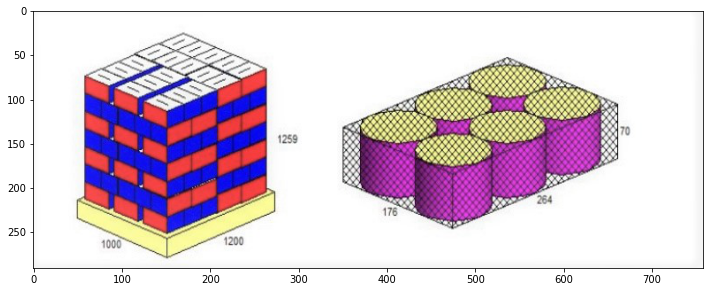

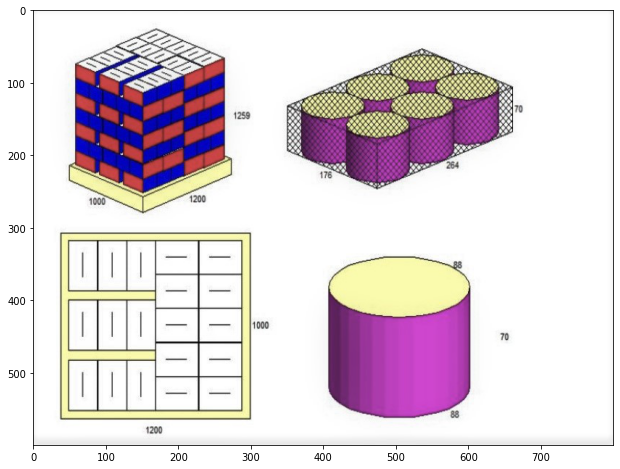

In [124]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    print("output_dict :",output_dict)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)